# Drone Model-Predictive Control

## Package Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from pydrake.all import (
    AbstractValue, AddMultibodyPlantSceneGraph,ConstantVectorSource, BasicVector,BallRpyJoint, DiagramBuilder,DirectCollocation, DirectTranscription,
    FiniteHorizonLinearQuadraticRegulatorOptions, FindResourceOrThrow, LinearSystem, Linearize, LeafSystem,ExternallyAppliedSpatialForce,
    LogVectorOutput, MultibodyPlant, MakeFiniteHorizonLinearQuadraticRegulator, MultibodyPlant,
    MathematicalProgram, MeshcatVisualizerParams, MeshcatVisualizerCpp, Parser, PortDataType,
    plot_system_graphviz, Propeller, PropellerInfo, PiecewisePolynomial, RandomSource, RandomDistribution, PrismaticJoint, 
    RigidBody, RigidTransform, Role, RotationMatrix, SceneGraph, Simulator, Solve, StartMeshcat, SpatialInertia,
    TrajectorySource, Trajectory, TimeStep, UnitInertia, VectorSystem, UnitInertia)

from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController)

from underactuated.meshcat_cpp_utils import MeshcatSliders

# from pydrake.multibody.plant import Wing





In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://252d90d3-1ad4-4a56-8b32-ebf5b097846b.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


## Define obstacle class 

In [3]:
class Obstacle():

    def __init__(self, sdf, p, body_name):

        self.sdf = sdf
        self.position = p
        self.body_name = body_name


    #parse sdf file to instantiate object and weld it to the simulation world
    def connect_obstacle_to_world(self, obstacle_plant, scene_graph):

        parser = Parser(obstacle_plant, scene_graph)

        self.model_instance = parser.AddModelFromFile(self.sdf)
        self.body = obstacle_plant.GetBodyByName(self.body_name, self.model_instance)
        obstacle_plant.WeldFrames(obstacle_plant.world_frame(), self.body.body_frame(), RigidTransform(p=self.position))

    # calculate 3D distance vector from quadrotor to object
    # quad_state parameter is truncated version of full state [x,y,z]
    def distance_from_object(self, quad_state):
        return quad_state - self.position



## Define Offline Trajectory Optimization Class

Find an optimal trajectory from an initial condition to a target destination, that minimizes time to target destination, and adheres to thrust limits

In [4]:
class QuadrotorTrajOpt():

    def __init__(self, init_state, target_state, num_time_samples, thrust_limit):
        self.init_state = init_state
        self.target_state = target_state
        self.num_time_samples = num_time_samples
        self.thrust_limit = thrust_limit


    def dir_col_opt(self, quadrotor_plant, quadrotor_context, obstacle_list):

        # use direct collocation to integrate quadrotor dynamics
        # DirectCollation classe performs Direct transcription trajectory optimization using nonlinear programming and collocation
        # It assumes a first-order hold on the input trajectory and a cubic spline representation of the state trajectory, and adds dynamic constraints 
        # (and running costs) to the midpoints as well as the breakpoints in order to achieve a 3rd order integration accuracy.
        dircol = DirectCollocation(quadrotor_plant,
                                quadrotor_context,
                                num_time_samples=self.num_time_samples,
                                minimum_timestep=0.05,
                                maximum_timestep=0.2)

        #Returns a reference to the MathematicalProgram associated with the trajectory optimization problem.
        prog = dircol.prog()

        # add constraint that enforces that all timesteps have equal duration (ensures more efficient optimization)
        dircol.AddEqualTimeIntervalsConstraints()

        # Returns placeholder decision variables (not actually declared as decision variables in the MathematicalProgram) 
        # associated with the input, u, but with the time-index undetermined.
        u = dircol.input()

        x = dircol.state()

        print(f"state = {x}")
        print(f"input = {u}")

        #TODO: constrain roll, pitch & yaw to be below 90

        # enforce collision avoidance constraints for each obstacle

        for obs in obstacle_list:
            # pass [x,y,z] position of quadrotor to get distance vector 
            quad_state_xyz = x[:3]
            distance_vector = obs.distance_from_object(quad_state_xyz)
            #x distance from center of object
            dircol.AddConstraintToAllKnotPoints(np.linalg.norm(distance_vector) >= 1.0 )
        
        #enforce constraint that drone cannot fly underground
        dircol.AddConstraintToAllKnotPoints(x[2]>= 0.0)

        #enforce constraint drone cannot fly above tree line
        dircol.AddConstraintToAllKnotPoints(x[2]<= 3.0)

        # enforce individual thrust limits for each propellor
        dircol.AddConstraintToAllKnotPoints(u[0] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[0])

        dircol.AddConstraintToAllKnotPoints(u[1] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[1])

        dircol.AddConstraintToAllKnotPoints(u[2] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[2])

        dircol.AddConstraintToAllKnotPoints(u[3] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[3])

        # add initial state constraint (first parameter is upper bound, second parameter is lower bound, 3rd parameter is variable being constrained)
        prog.AddBoundingBoxConstraint(self.init_state, self.init_state,
                                    dircol.initial_state())

        # add final state constraint
        prog.AddBoundingBoxConstraint(self.target_state, self.target_state,
                                    dircol.final_state())


        R = 100  # Cost on input "effort".
        dircol.AddRunningCost(R * u[0]**2)
        dircol.AddRunningCost(R * u[1]**2)
        dircol.AddRunningCost(R * u[2]**2)
        dircol.AddRunningCost(R * u[3]**2)

        # Add a final cost equal to the total duration.
        # dircol.AddFinalCost(dircol.time())

        # Construct an initial guess at an optimal trajectory
        # PiecewisePolynomial.FirstOrderHold Constructs a piecewise linear PiecewisePolynomial using matrix samples.
        breaks = [0., 4.]
        samples = np.column_stack((self.init_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(breaks, samples)  # yapf: disable

        dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

        result = Solve(prog)
        assert (result.is_success())

        u_trajectory = dircol.ReconstructInputTrajectory(result)
        x_trajectory = dircol.ReconstructStateTrajectory(result)

        return u_trajectory, x_trajectory

    def create_lqr_stabilizer(self, x_trajectory, u_trajectory, quadrotor_plant, quadrotor_context):
        options = FiniteHorizonLinearQuadraticRegulatorOptions()
        options.x0 = x_trajectory
        options.u0 = u_trajectory
        
        #define state penalty matrix with a 10 to 1 ratio on positions vs velocites
        #[x,y,z,roll,pitch,yaw, xdot, ydot, zdot, rolldot, pitchdot, yawdot]
        Q = np.diag([10.,10.,10.,10.,10.,10.,1.,1.,1.,1.,1.,1.])

        #final cost matrix
        options.Qf = Q
        # there are 4 thrust inputs, add minimum penalty to thrust
        R = np.eye(4)

        lqr_regulator = MakeFiniteHorizonLinearQuadraticRegulator(quadrotor_plant,
                                                  quadrotor_context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=R,
                                                  options=options)
        return lqr_regulator, options


class MpcController(VectorSystem):

    def __init__(self, quadrotor_plant, init_state, target_state, time_horizon, max_time_samples, thrust_limit, obstacle_list, u0):
        # define this system as having 12 inputs and 4 outputs
        VectorSystem.__init__(self, 12, 4)
        self.quadrotor_plant = quadrotor_plant
        self.init_state = init_state
        self.target_state = target_state
        self.time_horizon = time_horizon
        self.max_time_samples = max_time_samples
        self.thrust_limit = thrust_limit
        self.obstacle_list = obstacle_list
        self.current_step = 0

        self.current_output = u0

    def set_sim_context(self, sim_context):
        self.sim_context = sim_context


    def DoCalcVectorOutput(self, context, inp, state, output):

        # quadrotor_mutable_context = self.quadrotor_plant.GetMyMutableContextFromRoot(self.sim_context)
        quadrotor_context = self.quadrotor_plant.CreateDefaultContext()

        # fix input port of quadrotor with output of MPC controller, in order to perform linearization
        # this is the output from the previous iteration of the sim
        self.quadrotor_plant.get_input_port(0).FixValue(quadrotor_context, self.current_output)

        # print("DoCalcVectorOutput quad input value", quad_input_port.HasValue(quadrotor_context))

        # input into the controller is the state of the quadrotor
        # set the context equal to the current state
        quadrotor_context.SetContinuousState(inp)
        current_state = inp

        # print(f"cur_quad_state = {current_state}")
        # print(f"quadrotor current input = {output}")

        # mutable_state = quadrotor_mutable_context.get_continuous_state()

        ##################
        # Linearize system dynamics - Take first order taylor series expansions of system
        # around the operating point defined by quadrotor context
        ##################
        eq_check_tolerance = 10e6 # we do not need to be at an equilibrium point
        linear_quadrotor = Linearize(self.quadrotor_plant, quadrotor_context, \
        equilibrium_check_tolerance = eq_check_tolerance )

        linear_context = linear_quadrotor.CreateDefaultContext()
        linear_context.SetContinuousState(inp)


        # num_samples = min(self.time_horizon, self.max_time_samples - self.current_step +1)
        num_samples = self.time_horizon


        # print(f"num_samples in traj opt = {num_samples}")
        
        # use direct collocation to integrate quadrotor dynamics
        # DirectCollation classe performs Direct transcription trajectory optimization using nonlinear programming and collocation
        # It assumes a first-order hold on the input trajectory and a cubic spline representation of the state trajectory, and adds dynamic constraints 
        # (and running costs) to the midpoints as well as the breakpoints in order to achieve a 3rd order integration accuracy.
        # dircol = DirectCollocation(linear_quadrotor,
        #                         linear_context,
        #                         num_time_samples=num_samples,
        #                         minimum_timestep=0.05,
        #                         maximum_timestep=0.2)

        time_step = TimeStep(0.1)
        dircol = DirectTranscription(linear_quadrotor,
                        linear_context,
                        num_time_samples=num_samples,
                        fixed_timestep = time_step)
                

        #Returns a reference to the MathematicalProgram associated with the trajectory optimization problem.
        prog = dircol.prog()

        # add constraint that enforces that all timesteps have equal duration (ensures more efficient optimization)
        # dircol.AddEqualTimeIntervalsConstraints()

        # Returns placeholder decision variables (not actually declared as decision variables in the MathematicalProgram) 
        # associated with the input, u, but with the time-index undetermined.
        u = dircol.input()
        x = dircol.state()

        #print(f"state = {x}")
        #print(f"input = {u}")

        #TODO: contrain roll, pitch & yaw to be below 90

        # enforce collision avoidance constraints for each obstacle

        for obs in self.obstacle_list:
            # pass [x,y,z] position of quadrotor to get distance vector 
            quad_state_xyz = x[:3]
            distance_vector = obs.distance_from_object(quad_state_xyz)
            #x distance from center of object
            dircol.AddConstraintToAllKnotPoints(np.linalg.norm(distance_vector) >= 1.0 )
        
        #enforce constraint that drone cannot fly underground
        # dircol.AddConstraintToAllKnotPoints(x[2]>= 0)

        #enforce constraint drone cannot fly above tree line
        #dircol.AddConstraintToAllKnotPoints(x[2]<= 3)

        # enforce individual thrust limits for each propellor
        dircol.AddConstraintToAllKnotPoints(u[0] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[0])

        dircol.AddConstraintToAllKnotPoints(u[1] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[1])

        dircol.AddConstraintToAllKnotPoints(u[2] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[2])

        dircol.AddConstraintToAllKnotPoints(u[3] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[3])

        # add initial state constraint (first parameter is upper bound, second parameter is lower bound, 3rd parameter is variable being constrained)
        prog.AddBoundingBoxConstraint(current_state, current_state,
                                    dircol.initial_state())

        # TODO: add final state constraint (if we are within range)
        # prog.AddBoundingBoxConstraint(self.target_state, self.target_state,
        #                             dircol.final_state())

        # TODO: Add recursive feasibility constraint

        # add contraints on angle 
        angle_limit = 85
        dircol.AddConstraintToAllKnotPoints(x[3] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[3])
        dircol.AddConstraintToAllKnotPoints(x[4] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[4])
        dircol.AddConstraintToAllKnotPoints(x[5] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[5])
        dircol.AddConstraintToAllKnotPoints(x[6] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[6])
        dircol.AddConstraintToAllKnotPoints(x[7] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[7])
        dircol.AddConstraintToAllKnotPoints(x[8] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[8])
        dircol.AddConstraintToAllKnotPoints(x[9] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[9])
        dircol.AddConstraintToAllKnotPoints(x[10] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[10])
        dircol.AddConstraintToAllKnotPoints(x[11] <= angle_limit)
        dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[11])



        # Add quadratic cost on difference between current state and target state
        Q = [100.,100.,100.,100.,100.,100.,10.,10.,10.,10.,10.,10.]
        for i in range(len(inp)):
            dircol.AddRunningCost( Q[i]* (x[i] -  self.target_state[i])**2)
        

        R = 1  #  quadratic Cost on input "effort".
        dircol.AddRunningCost(R * u[0]**2)
        dircol.AddRunningCost(R * u[1]**2)
        dircol.AddRunningCost(R * u[2]**2)
        dircol.AddRunningCost(R * u[3]**2)

        # TODO: Add quadratic running cost that is function of difference between current 
        # state and target state

        # Add a final cost equal to the total duration.
        # dircol.AddFinalCost(dircol.time())

        # Construct an initial guess at an optimal trajectory
        # PiecewisePolynomial.FirstOrderHold Constructs a piecewise linear PiecewisePolynomial using matrix samples.
        breaks = [0., 4.]
        samples = np.column_stack((self.init_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(breaks, samples)  # yapf: disable

        dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

        # print("running solver")
        result = Solve(prog)
        assert (result.is_success())

        u_trajectory = dircol.ReconstructInputTrajectory(result)
        x_trajectory = dircol.ReconstructStateTrajectory(result)
        output[:] = u_trajectory.value(0).flatten()

        # output[:] = [10.0,10.0,10.0,10.0]

        self.current_output = output;

        # print(output)

        # self.current_step += 1



    # def DoCalcVectorTimeDerivatives(self, context, derivatives):
    #     pass

    # def DoCalcVectorDiscreteVariableUpdates(self, context, update, state):
    #     pass
        




## Run the Trajectory Optimization Simulations

In [8]:
# class ForceMux(LeafSystem):

#     def __init__(self):
#         LeafSystem.__init__(self)
#         self.DeclareAbstractInputPort("propeller_force",AbstractValue.Make(ExternallyAppliedSpatialForce()))
#         self.DeclareAbstractInputPort("wing_force",AbstractValue.Make(ExternallyAppliedSpatialForce()) )
#         self.DeclareAbstractOutputPort("spatial_forces", 
#         ExternallyAppliedSpatialForce(), 
#         self.OutputForces)


#     def OutputForces(self, context, output):
#         propeller_force = self.EvalVectorInput(context, 0)[0]
#         wing_force = self.EvalVectorInput(context, 0)[0]

#         print(propeller_force)
#         print(wing_force)
        
#         output.SetFromVector(np.concatenate(propeller_force, wing_force))
#         print(output)


def AddFloatingRpyJoint(plant, frame, instance):
    inertia = UnitInertia.SolidSphere(1.0)
    x_body = plant.AddRigidBody(
        "x", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("x", plant.world_frame(), x_body.body_frame(),
                       [1, 0, 0]))
    y_body = plant.AddRigidBody(
        "y", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("y", x_body.body_frame(), y_body.body_frame(),
                       [0, 1, 0]))
    z_body = plant.AddRigidBody(
        "z", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("z", y_body.body_frame(), z_body.body_frame(),
                       [0, 0, 1]))
    plant.AddJoint(BallRpyJoint("ball", z_body.body_frame(), frame))


def create_quadrotor(quadrotor_builder, world_plant, scene_graph, obstacles  ):

    for obs in obstacles:
        obs.connect_obstacle_to_world(world_plant, scene_graph)

    #### Define quadrotor MultiBodyPlant using Quadrotor .urdf and Propeller class
    quad_model= Parser(world_plant).AddModelFromFile("/work/Quadrotor_MPC/quadrotor.urdf")
    quad_body = world_plant.GetBodyByName("base_link", quad_model)
    quad_frame = world_plant.GetFrameByName("base_link")

    ###### Change coordinates from quaternion to rpy ######
    AddFloatingRpyJoint(world_plant, quad_frame, quad_model)

    #finalize the world plant
    world_plant.Finalize()

    p1_thrust_ratio = 1.0
    p1_moment_ratio = 0.0245
    prop1_pose = RigidTransform(p=[.1750,0,0])
    p2_thrust_ratio = 1.0
    p2_moment_ratio = -0.0245
    prop2_pose = RigidTransform(p=[0,.1750,0])
    p3_thrust_ratio = 1.0
    p3_moment_ratio = 0.0245
    prop3_pose = RigidTransform(p=[-.1750,0,0])
    p4_thrust_ratio = 1.0
    p4_moment_ratio = -0.0245
    prop4_pose = RigidTransform(p=[0,-.1750,0])

    prop1 = PropellerInfo(quad_body.index(), prop1_pose, p1_thrust_ratio, p1_moment_ratio);
    prop2 = PropellerInfo(quad_body.index(), prop2_pose, p2_thrust_ratio, p2_moment_ratio);
    prop3 = PropellerInfo(quad_body.index(), prop3_pose, p3_thrust_ratio, p3_moment_ratio);
    prop4 = PropellerInfo(quad_body.index(), prop4_pose, p4_thrust_ratio, p4_moment_ratio);

    props = quadrotor_builder.AddSystem(Propeller([prop1, prop2, prop3, prop4]))

    quadrotor_builder.Connect(props.get_spatial_forces_output_port(),
                    world_plant.get_applied_spatial_force_input_port());
    quadrotor_builder.Connect(world_plant.get_body_poses_output_port(),
                    props.get_body_poses_input_port());

    
    # fluid_density  = 1.225 # kg/m^3,  fluid density of air
    # surface_area = 0.144 # m^2
    # wing_pose = RigidTransform(p=[0,0,0])
    # wing = quadrotor_builder.AddSystem(Wing(quad_body.index(), surface_area, wing_pose,  fluid_density))

    # quadrotor_builder.Connect(wing.get_spatial_force_output_port(),
    #                 world_plant.get_applied_spatial_force_input_port())

    # quadrotor_builder.Connect(world_plant.get_body_poses_output_port(),
    #                 wing.get_body_poses_input_port())

    # force_mux = quadrotor_builder.AddSystem(ForceMux())

    # print(force_mux.get_input_port(0).get_data_type())
    # print(props.get_spatial_forces_output_port().get_data_type())
    # print(world_plant.get_applied_spatial_force_input_port().get_data_type())

    # quadrotor_builder.Connect(props.get_spatial_forces_output_port(),
    #                 force_mux.get_input_port(0))

    # quadrotor_builder.Connect(wing.get_spatial_forces_output_port(),
    #                 force_mux.get_input_port(1))

    # quadrotor_builder.Connect(force_mux.get_output_port(0), 
    #                 world_plant.get_applied_spatial_force_input_port())

    # quadrotor_builder.Connect(world_plant.get_body_poses_output_port(), wing.get_body_poses_input_port())


    

    print(f"world plant state output port data type {world_plant.get_state_output_port().get_data_type()}")
    print(f"world plant state output port size {world_plant.get_state_output_port().size()}")

    quadrotor_builder.ExportInput(props.get_command_input_port(), "prop_command")
    # quadrotor_builder.ExportInput(world_plant.get_geometry_query_input_port(), "geometry_query")
    quadrotor_builder.ExportOutput(world_plant.get_state_output_port(), "state")
    # quadrotor_builder.ExportOutput(world_plant.get_geometry_poses_output_port(), "geometry_pose")

    # Set up visualization in MeshCat
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(quadrotor_builder, scene_graph, meshcat)
    # end setup for visualization

    built_quadrotor = quadrotor_builder.Build()

    print(props.get_spatial_forces_output_port().get_data_type())
    print(world_plant.get_applied_spatial_force_input_port().get_data_type())


    print(f"input port 0 data type = {built_quadrotor.get_input_port(0).get_data_type()}")
    print(f"input port 0 size = {built_quadrotor.get_input_port(0).size()}")

    return built_quadrotor, visualizer

# Simulate nonlinear trajectory optimization + LQR stabilization of quadrotor
def run_non_linear_traj_opt_plus_lqr():
    #calculate optimal trajectory and simulation
    initial_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # target state for trajectory optimization
    final_state = [0, 6, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # limit of thrust force for each individual propellor
    thrust_limit = 5.0
    #we want to have an odd number
    num_time_samples = 21
    
    #insantiate builder to connect high level system components
    world_builder = DiagramBuilder()

    # instatiate builder to build quadrotor by connecting MultiBodyPlant + Propellers
    quadrotor_builder = DiagramBuilder()

    # instantiate traj opt class, used to implement nonlinear traj opt, lqr traj stabilization, linear mpc
    quad_traj_opt = QuadrotorTrajOpt(initial_state, final_state, num_time_samples, thrust_limit)

    # define world multibody plant containing quadrotor body and obstacles
    world_plant, scene_graph = AddMultibodyPlantSceneGraph(quadrotor_builder, time_step = 0.0)

    # world_plant = MultibodyPlant(time_step = 0.0)
    # scene_graph = world_builder.AddSystem(SceneGraph())

    ##################### load obtacle course files  #######################
    obstacles = []
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[2, 2, 0.5],"tree_body"))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[-2, 2, 0.5], "tree_body"))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[0, 4, 0.5], "tree_body"))

    ####### Import .urdf files, connect quad body to propellers, connect geometry to scene graph
    built_quadrotor, visualizer = create_quadrotor(quadrotor_builder, world_plant, scene_graph, obstacles)

    ####### Add quadrotor to top level diagram builder #####
    world_builder.AddSystem(built_quadrotor)

    quadrotor_context = built_quadrotor.CreateDefaultContext()

    world_context = world_plant.CreateDefaultContext()

    cont_state = quadrotor_context.get_state().get_continuous_state()
    state_vector = cont_state.get_vector()

    print(cont_state.size())
    print(state_vector)


    # # run nonlinear traj opt to generate optimal trajectory offline
    u_trajectory, x_trajectory = quad_traj_opt.dir_col_opt(built_quadrotor, quadrotor_context, obstacles)

    print("trajectory optimization completed")
    # input_source = world_builder.AddSystem(TrajectorySource(u_trajectory))
    # world_builder.Connect(input_source.get_output_port(0), built_quadrotor.get_input_port(0) )
    
    # # # define lqr stabilizing controller to regulate quadrotor toward desired optimal trajectory
    lqr_regulator, options = quad_traj_opt.create_lqr_stabilizer(x_trajectory, u_trajectory, built_quadrotor, quadrotor_context)
   
    # # add the quadrotor and lqr controller to the builder
    lqr_regulator = world_builder.AddSystem(lqr_regulator)


    # # get the end time defined by the trajectory optimization, in order to tell simulation when to complete
    end_time = options.u0.end_time()


    # # # # connect the LQR controller to the quadrotor
    world_builder.Connect(lqr_regulator.get_output_port(0), built_quadrotor.get_input_port(0))
    world_builder.Connect(built_quadrotor.get_output_port(0), lqr_regulator.get_input_port(0))



    # # #connect loggers to log state and input over the course of sim
    # input_logger = LogVectorOutput(lqr_regulator.get_output_port(0), world_builder)
    # state_logger = LogVectorOutput(world_plant.get_output_port(0), builder)


    # Set up a simulator to run this diagram
    diagram = world_builder.Build()


    simulator = Simulator(diagram)
    sim_context = simulator.get_mutable_context()
    sim_context.SetContinuousState(initial_state)
    cont_state = sim_context.get_continuous_state()


    # built_quadrotor.get_input_port(0).FixValue(sim_context, [0.5,0.5,0.5,0.5])
    # print(f"quad_context continous state vector = {cont_state.get_vector()}")
    # print(f"quad_context parameters = {sim_context.get_parameters().get_numeric_parameters().get_data()}")

    # end_time = 10.0
    simulator.set_target_realtime_rate(1.0)
    meshcat.AddButton('Stop Simulation')

    visualizer.StartRecording()
    while simulator.get_context().get_time() < end_time:
        
        simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)
        # print(f"quad_context continous state vector = {cont_state.get_vector()}")

    meshcat.DeleteAddedControls()

    visualizer.StopRecording()
    visualizer.PublishRecording()

    # fig, ax = plt.subplots(2,1)
    # ax[0].plot(options.u0.get_segment_times(),
    #             options.u0.vector_values(options.u0.get_segment_times()).T)
    # input_log = input_logger.FindLog(simulator.get_context())
    # ax[0].plot(input_log.sample_times(), input_log.data().T)
    # ax[0].legend(('u nominal','u actual'))

    # ax[1].plot(options.x0.get_segment_times(),
    #             options.x0.vector_values(options.x0.get_segment_times()).T, 'b')
    # state_log = state_logger.FindLog(simulator.get_context())
    # ax[1].plot(state_log.sample_times(), state_log.data().T, 'g')
    # ax[1].legend(('x nominal','x actual'))
    # display(plt.show())


def run_linear_mpc():

    #calculate optimal trajectory and simulation
    initial_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # target state for trajectory optimization
    final_state = [0, 6, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # limit of thrust force for each individual propellor
    thrust_limit = 10.0
    
    #we want to have an odd number
    num_time_samples = 81
    # number of samples into future we will run trajectory optimization
    time_horizon = 21

    # instatiate diagram builder used to connect the different system components
    builder = DiagramBuilder()

    # define world multibody plant & scene graph, containing obstacles and quadrotor
    world_plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)

    # instantiate traj opt class, used to implement nonlinear traj opt, lqr traj stabilization, linear mpc
    quad_traj_opt = QuadrotorTrajOpt(initial_state, final_state, num_time_samples, thrust_limit)

    # add obstacles to the simulated world
    obstacles = []
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[2, 2, 0.5],"tree_body"))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[-2, 2, 0.5], "tree_body"))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[0, 4, 0.5], "tree_body"))
    for obs in obstacles:
        obs.connect_obstacle_to_world(world_plant, scene_graph)

    #finalize the world plant
    world_plant.Finalize()



    # define the quadrotor plant using drake built in quadrotor plant class
    # this is a System, not a MultiBodyPlant
    quadrotor_plant = QuadrotorPlant()
    # quadrotor_context = quadrotor_plant.CreateDefaultContext()
    
    quadrotor_plant = builder.AddSystem(quadrotor_plant)

    init_ctrl_out = [0., 0., 0., 0.]
    mpc_controller = MpcController(quadrotor_plant, initial_state, final_state, time_horizon, num_time_samples, thrust_limit, obstacles, init_ctrl_out)
    mpc_controller = builder.AddSystem(mpc_controller)

    print(mpc_controller.get_output_port(0).get_data_type())
    print(mpc_controller.get_output_port(0).size())
    print(quadrotor_plant.get_output_port(0).get_data_type())
    print(quadrotor_plant.get_output_port(0).size())

    # connect the MPC controller to the quadrotor
    builder.Connect(mpc_controller.get_output_port(0), quadrotor_plant.get_input_port(0))
    builder.Connect(quadrotor_plant.get_output_port(0), mpc_controller.get_input_port(0))

    # quad_context = quadrotor_plant.CreateDefaultContext()
    # print(quadrotor_plant.get_input_port(0).HasValue(quad_context))


    # Set up visualization in MeshCat
    QuadrotorGeometry.AddToBuilder(builder, quadrotor_plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    ################# Run Simulation ####################
    #Set up a simulator to run this diagram
    diagram = builder.Build()

    quad_context = quadrotor_plant.CreateDefaultContext()
    print(quadrotor_plant.get_input_port(0).HasValue(quad_context))



    simulator = Simulator(diagram)
    sim_context = simulator.get_mutable_context()
    sim_context.SetContinuousState(initial_state)

    # pass sim context into MpC controller to be used for linearization of dynamics
    mpc_controller.set_sim_context(sim_context)
    quadrotor_context = quadrotor_plant.GetMyMutableContextFromRoot(sim_context)

    # quadrotor_plant.get_input_port(0).FixValue(quadrotor_context, [10.,10.,10.,10.])
    end_time = 10.0
    simulator.set_target_realtime_rate(10.0)
    meshcat.AddButton('Stop Simulation')
    while simulator.get_context().get_time() < end_time:

        simulator.AdvanceTo(sim_context.get_time() + 0.1)

    meshcat.DeleteAddedControls()


# Simulate nonlinear trajectory optimization + LQR stabilization of quadrotor
run_non_linear_traj_opt_plus_lqr()

# Simulate MPC of quadrotor
# run_linear_mpc()



world plant state output port data type PortDataType.kVectorValued
world plant state output port size 12
PortDataType.kAbstractValued
PortDataType.kAbstractValued
input port 0 data type = PortDataType.kVectorValued
input port 0 size = 4
12
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
state = [Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous) Variable('x(3)', Continuous)
 Variable('x(4)', Continuous) Variable('x(5)', Continuous)
 Variable('x(6)', Continuous) Variable('x(7)', Continuous)
 Variable('x(8)', Continuous) Variable('x(9)', Continuous)
 Variable('x(10)', Continuous) Variable('x(11)', Continuous)]
input = [Variable('u(0)', Continuous) Variable('u(1)', Continuous)
 Variable('u(2)', Continuous) Variable('u(3)', Continuous)]
trajectory optimization completed


## Wind Turbulence Model 

A standard mathematical model used to approximate continuous wind gusts is the Dryden Wind Turbulence Model.

altitude in region 3: > 2000 ft
sigma_u = 15.6, L_u = 1750
sigma_v = 15.6, L_v = 1750 
sigma_w = 15.6, L_w = 1750 
vehicle_speed = 5


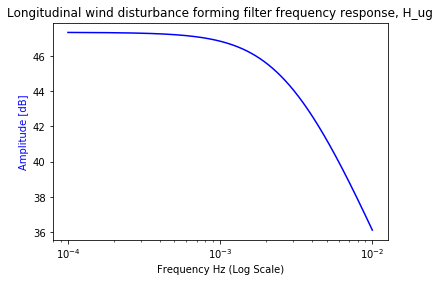

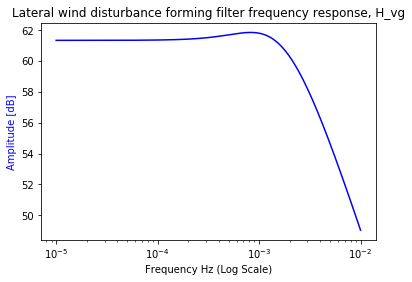

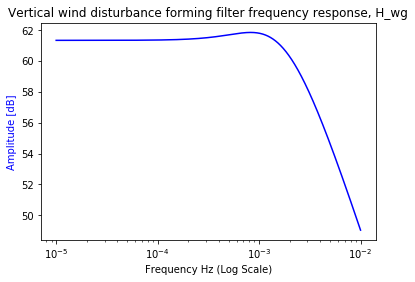

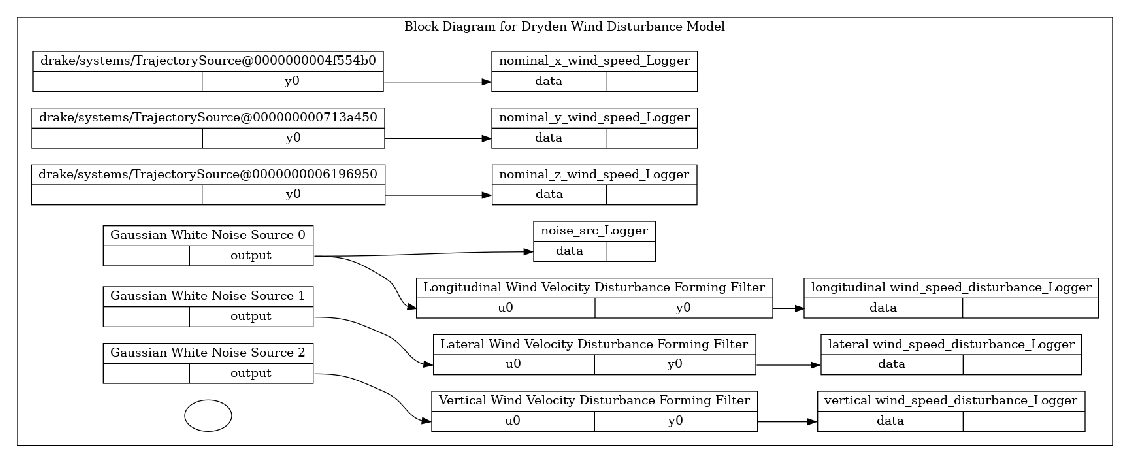

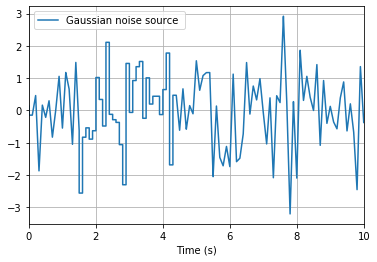

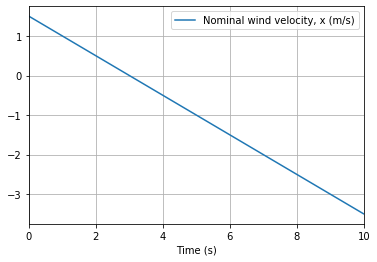

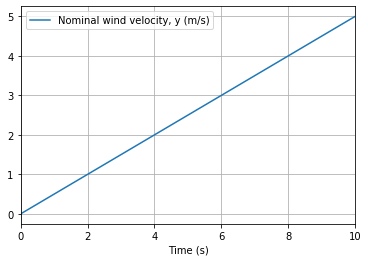

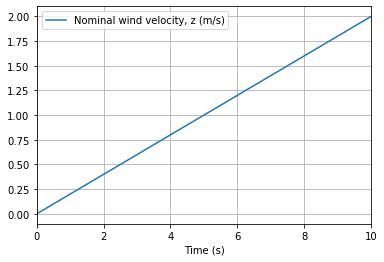

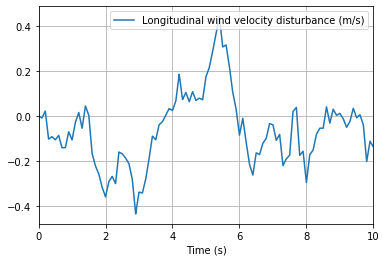

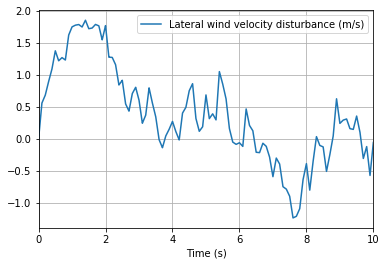

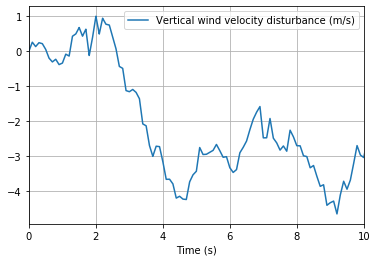

In [6]:
# the dryden noise class 
fig_num = 0;

class DrydenWindDisturbance:

    '''Generate colored noise used to represent wind turbulence using the Dryden Wind Disturbance Model.'''

    def __init__(self, sampling_interval):

        # define the number of outputs for the gaussian noise source used to generate 
        # Dryden wind disturbance
        self.sampling_interval = sampling_interval

    def calculate_model_parameters(self, altitude, wind_speed):
        #########################
        # turbulence intensities( sigma_u, sigma_v, sigma_w), and turbulence lengths (L_u, L_v, L_w) are 
        # functions of altitude h, divided into three regions:
        #
        # wind_speed = 15 knots for light turbulence, 30 knots for moderate turbulence, 
        # 45 knots for severe turbulence
        #
        # units of altitude in ft



        ######################## Region 1: altitude < 1000
        if (altitude < 1000):

            sigma_w = 0.1 * wind_speed
            
            sigma_v  = sigma_w / ( (0.177 + 0.000823* altitude) ** 0.4 )

            sigma_u = sigma_v

            L_w = altitude

            L_v = altitude / ( (0.177 + 0.000823* altitude) ** 1.2 )

            L_u = L_v

        ######################### Region 2: 1000 < altitude < 2000
        # Calculated be performing linear interpolation between regions 1 & 3

        elif (1000 <= altitude <= 2000):
            print("altitude in region 2: 1000 - 2000 ft, not implemented")
            # typically implemented as linear interpolation between parameter values in high altitude region 
            # and parameter values in the low altitude region
            # not implemented, as this project is only concerned with high altitude region

        ######################### Region 3: altitude > 2000
        else:
            print("altitude in region 3: > 2000 ft")
            # in this region, turbulence is assumed isotropic, which leads to turbulence scale length to be constant
            L_u = L_v = L_w = 1750

            # typically sigma_u, sigma_v, and sigma_w are represented with a lookup table, but here 
            # they will be approximated with formulas

            # we are in light turbelence regime, wind speed in knots
            if wind_speed <= 15:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.000375) + 6
                if (altitude > 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.00025) + 8.5
            # medium turbulence
            elif 15 < wind_speed <= 45:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.000875) + 7.5
                if (altitude > 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.0001935) + 11.774
            # high turbulence, wind_speed > 45
            else:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.0002) + 15
                if (4000 <altitude < 8000 ):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.00009375) + 22.625
                if (altitude >= 8000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.000221) + 25.515

        return sigma_u, sigma_v, sigma_w, L_u, L_v, L_w

    
    def ug_filter(self, sigma_u, L_u, vehicle_speed):

        global fig_num

        # H_ug(s) = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed)) * (1 / (1 + L_u/V s))

        # define gain for transfer function that will produce PSD of the linear wind velocity in direction u)
        H_ug_gain = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed))
        #print(f"H_ug_gain = {H_ug_gain}")
        
        #define lowpass filter that will produce longitudinal linear wind disturbance
        # highest order terms are first in the array

        H_ug_tf = signal.TransferFunction(H_ug_gain, [ L_u / vehicle_speed, 1] )

        #print(H_ug_tf)

        w, H = signal.freqresp(H_ug_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Longitudinal wind disturbance forming filter frequency response, H_ug')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        #plt.xlabel('Frequency [rad/sec]')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_ug_ss = H_ug_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_ug_sys = LinearSystem(H_ug_ss.A, H_ug_ss.B, H_ug_ss.C, H_ug_ss.D )

        return self.H_ug_sys

    def vg_filter(self, sigma_v, L_v, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_vg_gain = sigma_v * np.sqrt(2* L_v / np.pi * vehicle_speed)
        
        #print(f"H_vg_gain = {H_vg_gain}")

        # highest order terms are first in the array
        H_vg_tf = signal.TransferFunction([(H_vg_gain * 2 * np.sqrt(3) * L_v / vehicle_speed ), H_vg_gain ], \
        [(2*L_v/vehicle_speed)**2, 4*L_v/vehicle_speed, 1] )

        #print(H_vg_tf)

        w, H = signal.freqresp(H_vg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Lateral wind disturbance forming filter frequency response, H_vg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_vg_ss = H_vg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_vg_sys = LinearSystem(H_vg_ss.A, H_vg_ss.B, H_vg_ss.C, H_vg_ss.D )

        return self.H_vg_sys

    def wg_filter(self, sigma_w, L_w, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_wg_gain = sigma_w * np.sqrt(2* L_w / np.pi * vehicle_speed)
        
        #print(f"H_wg_gain = {H_wg_gain}")

        # highest order terms are first in the array
        H_wg_tf = signal.TransferFunction([(H_wg_gain * 2 * np.sqrt(3) * L_w / vehicle_speed ), H_wg_gain ], \
        [(2*L_w/vehicle_speed)**2, 4*L_w/vehicle_speed, 1] )

        #print(H_wg_tf)

        w, H = signal.freqresp(H_wg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Vertical wind disturbance forming filter frequency response, H_wg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_wg_ss = H_wg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_wg_sys = LinearSystem(H_wg_ss.A, H_wg_ss.B, H_wg_ss.C, H_wg_ss.D )

        return self.H_wg_sys


    

    def connect_Dryden_noise_src(self, builder):

        # define gaussiang random noise input
        gaussian_distribution = RandomDistribution(1) # parameter of 1 = gaussian distribution
        self.white_noise_src0 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src1 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src2 = RandomSource(gaussian_distribution, 1, self.sampling_interval)


        builder.AddSystem(self.white_noise_src0)
        builder.AddSystem(self.white_noise_src1)
        builder.AddSystem(self.white_noise_src2)

        builder.AddSystem(self.H_ug_sys)
        builder.AddSystem(self.H_vg_sys)
        builder.AddSystem(self.H_wg_sys)


        builder.Connect(self.white_noise_src0.get_output_port(0), self.H_ug_sys.get_input_port(0))
        builder.Connect(self.white_noise_src1.get_output_port(0), self.H_vg_sys.get_input_port(0))
        builder.Connect(self.white_noise_src2.get_output_port(0), self.H_wg_sys.get_input_port(0))


        self.white_noise_src0.set_name("Gaussian White Noise Source 0")
        self.white_noise_src1.set_name("Gaussian White Noise Source 1")
        self.white_noise_src2.set_name("Gaussian White Noise Source 2")


        self.H_ug_sys.set_name("Longitudinal Wind Velocity Disturbance Forming Filter")
        self.H_vg_sys.set_name("Lateral Wind Velocity Disturbance Forming Filter")
        self.H_wg_sys.set_name("Vertical Wind Velocity Disturbance Forming Filter")

        return [self.white_noise_src0, self.white_noise_src1, self.white_noise_src2]


# simulation time
sim_time = 10
time_step = 0.1

num_time_steps = int(sim_time / time_step)


sampling_interval = 0.1 # seconds
altitude = 3000 #ft
wind_speed = 50 # knots (worst case parameters)
vehicle_speed = 5 # m/s (specify worst case parameters)

dryden_noise = DrydenWindDisturbance(sampling_interval)

### Calculate Dryden model parameters
sigma_u, sigma_v, sigma_w, L_u, L_v, L_w = dryden_noise.calculate_model_parameters(altitude, wind_speed)

print(f"sigma_u = {sigma_u}, L_u = {L_u}") 
print(f"sigma_v = {sigma_v}, L_v = {L_v} ")
print(f"sigma_w = {sigma_w}, L_w = {L_w} ")
print(f"vehicle_speed = {vehicle_speed}")

##################################################################################
####### define the linear systems used to model wind velocity disturbances in each direction 
##################################################################################
H_ug_sys = dryden_noise.ug_filter(sigma_u, L_u, vehicle_speed)
H_vg_sys = dryden_noise.vg_filter(sigma_v, L_v, vehicle_speed)
H_wg_sys = dryden_noise.wg_filter(sigma_w, L_w, vehicle_speed)


##################################################################################
####### define nominal velocity trajectory in X, Y, and Z directions #############
##################################################################################
breaks = [0, sim_time]
init_x_velocity = [1.5]
final_x_velocity = [-3.5]
init_y_velocity = [0.0]
final_y_velocity = [5.0]
init_z_velocity = [0.0]
final_z_velocity = [2.0]
x_samples = np.column_stack((init_x_velocity, final_x_velocity))
y_samples = np.column_stack((init_y_velocity, final_y_velocity))
z_samples = np.column_stack((init_z_velocity, final_z_velocity))
wind_vel_x_traj = PiecewisePolynomial.FirstOrderHold(breaks, x_samples)
wind_vel_y_traj = PiecewisePolynomial.FirstOrderHold(breaks, y_samples)
wind_vel_z_traj = PiecewisePolynomial.FirstOrderHold(breaks, z_samples)



builder = DiagramBuilder()



nom_wind_x_source = builder.AddSystem(TrajectorySource(wind_vel_x_traj))
nom_wind_y_source = builder.AddSystem(TrajectorySource(wind_vel_y_traj))
nom_wind_z_source = builder.AddSystem(TrajectorySource(wind_vel_z_traj))

logger_x = LogVectorOutput(nom_wind_x_source.get_output_port(), builder)
logger_x.set_name('nominal_x_wind_speed_Logger')
logger_y = LogVectorOutput(nom_wind_y_source.get_output_port(), builder)
logger_y.set_name('nominal_y_wind_speed_Logger')
logger_z = LogVectorOutput(nom_wind_z_source.get_output_port(), builder)
logger_z.set_name('nominal_z_wind_speed_Logger')



##################################################################################
####### Connect noise Dryden noise generators #############
##################################################################################

[white_noise_src0, white_noise_src1, white_noise_src2]  = dryden_noise.connect_Dryden_noise_src(builder)

# logger that records the state trajectory during simulation
logger_ug = LogVectorOutput(H_ug_sys.get_output_port(), builder)
logger_ug.set_name('longitudinal wind_speed_disturbance_Logger')
logger_vg = LogVectorOutput(H_vg_sys.get_output_port(), builder)
logger_vg.set_name('lateral wind_speed_disturbance_Logger')
logger_wg = LogVectorOutput(H_wg_sys.get_output_port(), builder)
logger_wg.set_name('vertical wind_speed_disturbance_Logger')


# logger that records the state trajectory during simulation
logger_noise = LogVectorOutput(white_noise_src0.get_output_port(), builder)
logger_noise.set_name('noise_src_Logger')

diagram = builder.Build()

############### Visualize 
# give names to the blocks (just to make the plot nicer)
diagram.set_name('Block Diagram for Dryden Wind Disturbance Model')
# plot current diagram
plt.figure(fig_num, figsize=(20, 10))
fig_num += 1
plot_system_graphviz(diagram)


# set up a simulator
simulator = Simulator(diagram)

context = simulator.get_mutable_context()
context.SetTime(0.) # reset current time

# simulate from zero to sim_time
simulator.Initialize()
sim_context = simulator.get_mutable_context()
while simulator.get_context().get_time() < sim_time:
    simulator.AdvanceTo(simulator.get_context().get_time() + time_step )


############### Plot gaussian noise source output ######################

plt.figure(fig_num)
fig_num +=1
# longitudinal wind velocity as a function of time
noise_log = logger_noise.FindLog(context)
plt.plot(
    noise_log.sample_times(),
    noise_log.data()[0,:],
    label='Gaussian noise source '
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()


############### Plot Nominal wind velocity, x direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_x = logger_x.FindLog(context)
plt.plot(
    log_x.sample_times(),
    log_x.data()[0,:],
    label='Nominal wind velocity, x (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

############### Plot Nominal wind velocity, y direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_y = logger_y.FindLog(context)
plt.plot(
    log_y.sample_times(),
    log_y.data()[0,:],
    label='Nominal wind velocity, y (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

############### Plot Nominal wind velocity, z direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_z = logger_z.FindLog(context)
plt.plot(
    log_z.sample_times(),
    log_z.data()[0,:],
    label='Nominal wind velocity, z (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()



############### Plot Longitudinal wind disturbance ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_ug = logger_ug.FindLog(context)
plt.plot(
    log_ug.sample_times(),
    log_ug.data()[0,:],
    label='Longitudinal wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()


############### Plot Lateral wind disturbance ######################

plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_vg = logger_vg.FindLog(context)
plt.plot(
    log_vg.sample_times(),
    log_vg.data()[0,:],
    label='Lateral wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()



############### Plot vertical wind disturbance ######################


plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_wg = logger_wg.FindLog(context)
plt.plot(
    log_wg.sample_times(),
    log_wg.data()[0,:],
    label='Vertical wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()






############### PSD of wind disturbance ######################

#print(len((log.data()[0,:])) )
#plt.figure(fig_num)
#fig_num +=1
#fs = vehicle_speed
#fs = 1.0
#f, PSD_ug = signal.welch(log_ug.data()[0,:], fs, nperseg=64)
#plt.semilogy(f, PSD_ug)
#plt.ylim([0.5e-3, 1])
#plt.xlabel('spatial frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
#plt.show()











<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=252d90d3-1ad4-4a56-8b32-ebf5b097846b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>